In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans
from google.colab import files
import io

In [48]:
# --- BAGIAN 1: LOAD DATA ---
# Coba baca file langsung jika sudah diupload ke sidebar
try:
    filename = 'dataset_final_clean_stopword.csv'
    df = pd.read_csv(filename)
    print(f"Berhasil membaca {filename} dari direktori.")
except FileNotFoundError:
    print("File belum ditemukan. Silakan upload file CSV Anda sekarang:")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    df = pd.read_csv(io.BytesIO(uploaded[filename]))

Berhasil membaca dataset_final_clean_stopword.csv dari direktori.


In [49]:
# Bersihkan data (hapus baris kosong pada kolom text jika ada)
# Pastikan nama kolom teks Anda sesuai, di sini diasumsikan 'text_clean'
df = df.dropna(subset=['text_clean'])
print(f"Jumlah data: {len(df)} baris")

Jumlah data: 1456 baris


In [50]:
# ==========================================
# BAGIAN 3: VEKTORISASI (TF-IDF & Count)
# ==========================================
print("\n--- MENYIAPKAN VEKTOR DATA ---")

# 1. TF-IDF untuk K-Means (dan Elbow)
# min_df=2: Hapus kata yang muncul kurang dari 2 kali (typo/sangat jarang)
tfidf_vectorizer = TfidfVectorizer(max_features=2000, min_df=2)
X_tfidf = tfidf_vectorizer.fit_transform(df['text_clean'])

# 2. Count Vectorizer untuk LDA
count_vectorizer = CountVectorizer(max_features=2000, min_df=2)
X_count = count_vectorizer.fit_transform(df['text_clean'])


--- MENYIAPKAN VEKTOR DATA ---



--- MENJALANKAN ELBOW METHOD ---


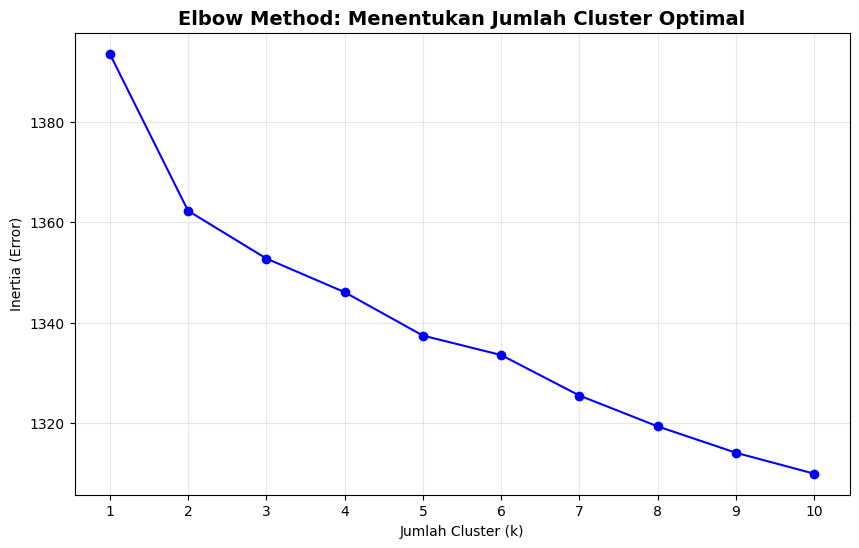

In [51]:
# ==========================================
# BAGIAN 4: ELBOW METHOD (BARU)
# ==========================================
print("\n--- MENJALANKAN ELBOW METHOD ---")
inertias = []
k_range = range(1, 11)  # Coba cluster 1 sampai 10

for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(X_tfidf)
    inertias.append(kmeans_test.inertia_)

# Visualisasi Elbow
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linestyle='-', color='b')
plt.title('Elbow Method: Menentukan Jumlah Cluster Optimal', fontsize=14, fontweight='bold')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia (Error)')
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.show()

In [52]:
# ==========================================
# BAGIAN 5: MODELING (K-MEANS & LDA)
# ==========================================
print("\n--- MELATIH MODEL FINAL ---")

# A. K-Means Final (Misal kita pilih k=3 berdasarkan asumsi/elbow)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster_kmeans'] = kmeans.fit_predict(X_tfidf)

# B. LDA Topic Modeling
n_topics = 3
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_count)


--- MELATIH MODEL FINAL ---


LatentDirichletAllocation(n_components=3, random_state=42)


--- MENAMPILKAN VISUALISASI HASIL ---


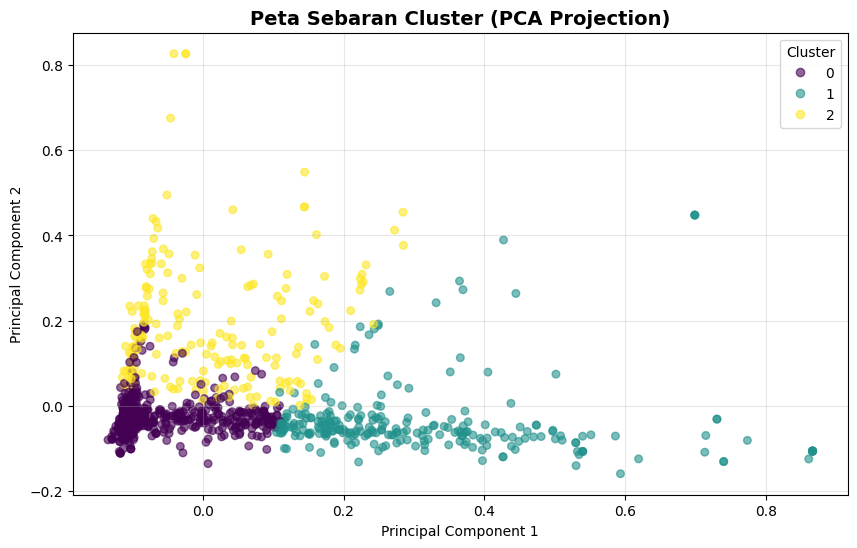

In [53]:
# ==========================================
# BAGIAN 6: VISUALISASI PROFESIONAL
# ==========================================
print("\n--- MENAMPILKAN VISUALISASI HASIL ---")

# 1. PCA SCATTER PLOT (Peta Sebaran Cluster)
pca = PCA(n_components=2)
coords = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 6))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=df['cluster_kmeans'], cmap='viridis', alpha=0.6, s=30)
plt.title('Peta Sebaran Cluster (PCA Projection)', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True, alpha=0.3)
plt.show()

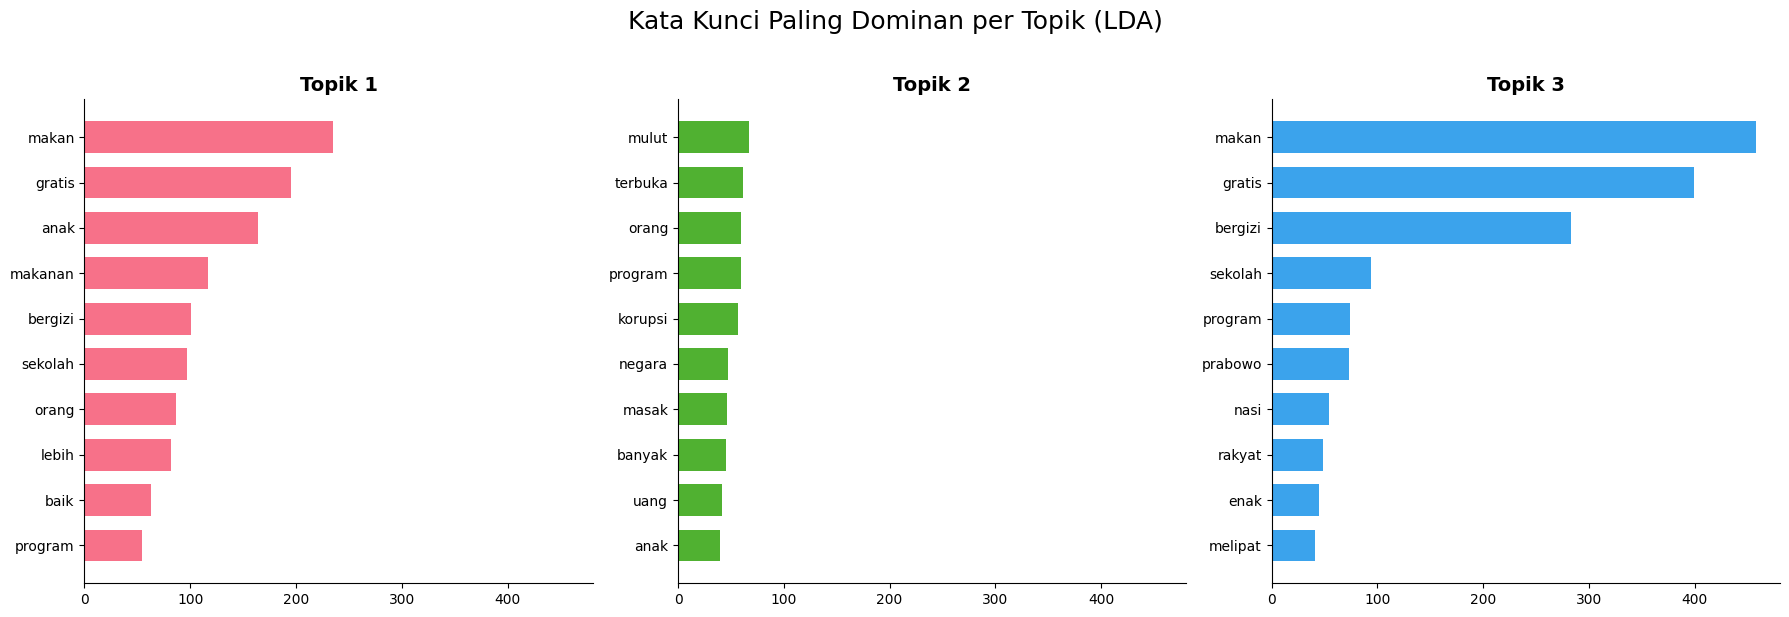

In [54]:
# 2. BAR CHART (Kata Kunci per Topik)
feature_names = count_vectorizer.get_feature_names_out()
n_top_words = 10
colors = sns.color_palette("husl", n_topics)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
axes = axes.flatten()

for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7, color=colors[topic_idx])
    ax.set_title(f'Topik {topic_idx +1}', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle('Kata Kunci Paling Dominan per Topik (LDA)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


Menampilkan WordCloud...


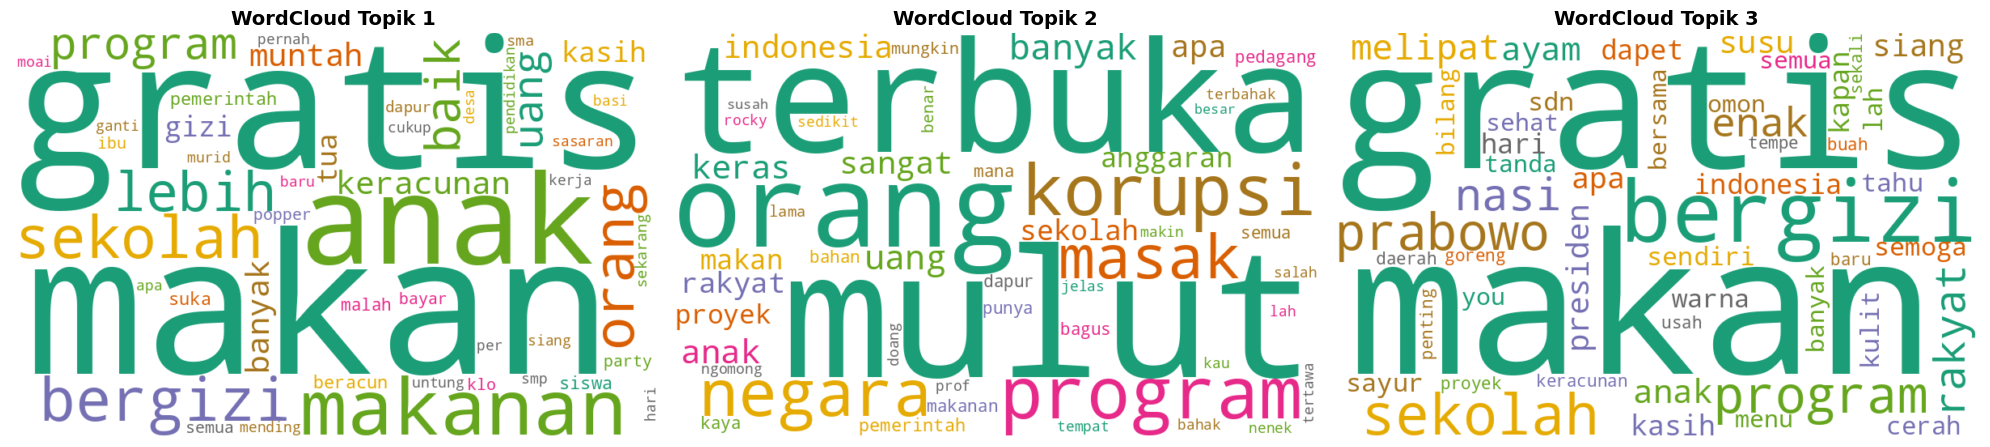

In [55]:
# 3. WORDCLOUD
print("\nMenampilkan WordCloud...")
plt.figure(figsize=(20, 6))

for i in range(n_topics):
    plt.subplot(1, 3, i+1)
    topic_words = {feature_names[j]: lda.components_[i][j] for j in lda.components_[i].argsort()[:-50:-1]}

    wc = WordCloud(background_color='white', width=800, height=500, colormap='Dark2', random_state=42)
    wc.generate_from_frequencies(topic_words)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud Topik {i+1}', fontsize=14, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()